## Bayes Model - Multinomial Classification of Textual Data

The objective of this work is to perform multinomial classification of products based on a text description. Initial data exploration, feature exploration and discussions of performance metrics is given in [this notebook](./initial_data_analysis) This notebook shows an implementation of a simple Bayes text classifier and some parameter tuning. This work is an early version of how an overall project might look, so we included several recommendations for future work.



In [7]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import import_ipynb
from initial_data_analysis import import_format_data,display_performance


In [2]:
#load data
train_data = import_format_data('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv')
test_data = import_format_data('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv')


## Model and Parameter Tuning

For this task, we will use a multinomial Naïve Bayes classifier. The features will be a count vector of the tokens generated from the product descriptions. The labels will be the product categories. This section shows the implementation of the naïve Bayes classifier model, model tuning and performance of level 1 and level 2 category classification.

### Naïve Bayes Multinomial Classifier - Category Level 1 

First, we look at the classifier performance for level 1 product category classification.

For a very simple classifier setup (i.e. no additional data processing beyond basic token count vectorizing and default parameters for the scikit learn Bayes multinomial classifier), we show a classification accuracy of 85.0%.

The confusion matrix breaks down the performance of each label to give us more details about performance. The rows show the actual prediction label and the columns shows the classifier's prediction. The color of the grid denotes the density of the actual/predicted label. A perfect classifier would show only the diagonal populated. This confusion matrix is normalized by row. There are several interesting aspects to note in this confusion matrix. For the "1208" labels, the classifier almost always predicted "4015". For the "4015" labels, the classifier performs nearly perfectly. Most incorrect predictions predict the "4015" label. If we look back to the data analysis where we looked at the distribution of training labels, we see that the "4015" label comprised a large portion of the training set. In other words, the classifier's accuracy is likely biased as a result of the bias in the training set.

Finally, we do some tuning of the classifier to see if there are some better parameter choices for our machine learning model. We perform a grid search of the following parameters: the removing/not removing stop words from the product descriptions, use of 1- or 1- and 2- grams, additive smoothing parameter in the Bayes classifier and presence/absence of the fit prior in the multinomial Bayes classifier. This grid search revealed the best parameters were using 1- and 2- grams, not removing stop words, alpha of 1e-4 and keeping fit prior from the Bayes calculation, which yielded accuracy of 88.9%

Overall Training Set Accuracy:  0.8803548504435631
Cross-validated Training Set Accuracy: 0.86 +/- 0.00
Test Set Accuracy:  0.85021


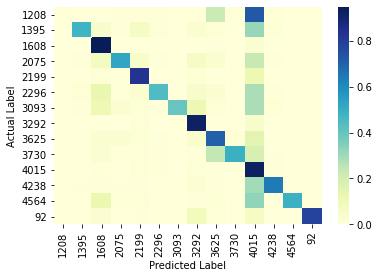

In [3]:
#setting up a pipeline to ease parameter tuning later
bayes_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(),)])
bayes_pipeline.fit(train_data['description'], train_data['cat_1'])
display_performance(bayes_pipeline.named_steps['classifier'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(test_data['description']), test_data['cat_1'], 
                    bayes_pipeline.named_steps['vectorizer'].transform(train_data['description']), train_data['cat_1']
                   )

In [8]:
#grid search on a few different parameters we can tune
params = {'vectorizer__ngram_range': [(1, 1), (1, 2)],
          'vectorizer__stop_words': ('english', None),
          'classifier__fit_prior': (True, False),
          'classifier__alpha': [10e-9, 10e-5, 10e-1, 1]
    }

grid_search = GridSearchCV(bayes_pipeline, params, cv=5, n_jobs=-1)
grid_search.fit(train_data['description'], train_data['cat_1'])
print('Best train score after grid search: ', grid_search.best_score_)
print('')
print('Grid search resulting best parameters: ', grid_search.best_score_)
for param_name in sorted(params.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

print('')
print('Best test score after grid search: ', grid_search.score(test_data['description'], test_data['cat_1']))

Best train score after grid search:  0.9135548903040019

Grid search resulting best parameters:  0.9135548903040019
classifier__alpha: 0.0001
classifier__fit_prior: True
vectorizer__ngram_range: (1, 2)
vectorizer__stop_words: None

Best test score after grid search:  0.88814


Overall Training Set Accuracy:  0.9951374939218675
Cross-validated Training Set Accuracy: 0.91 +/- 0.00
Test Set Accuracy:  0.88842


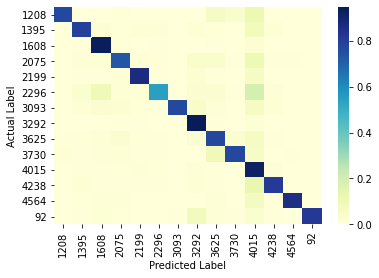

In [11]:
bayes_pipeline_low_alpha_optimal = bayes_pipeline.set_params(**grid_search.best_params_)
bayes_pipeline_low_alpha_optimal.fit(train_data['description'], train_data['cat_1'])
train_data['cat_1_predict'] = bayes_pipeline_low_alpha_optimal.predict(train_data['description'])

display_performance(bayes_pipeline_low_alpha_optimal.named_steps['classifier'], 
                    bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].transform(test_data['description']), test_data['cat_1'], 
                    bayes_pipeline_low_alpha_optimal.named_steps['vectorizer'].transform(train_data['description']), train_data['cat_1']
                   )

### Naïve Bayes Multinomial Classifier - Category Level 2

Next, we look at the classifier performance for level 2 product category classification. Our simple classifier setup (i.e. no additional data processing beyond basic token count vectorizing and default parameters for the scikit learn Bayes multinomial classifier), we show a classification accuracy of 75.2%. It is unsurprising that the accuracy would decrease since the number of classes increased from 14 to 109. One interesting idea for future work would be the progressive use of previous category as a feature. Previously we mentioned a potential human-in-the-loop system where the classification was human-assisted. In this example, if we were reasonably confident in the first level category either through the system's confidence or confirmation from the user, that category might be used as a feature for better second level category classification.

The confusion matrix isn't shown here because there are so many classes that its' usefulness is questionable.

Finally, we did the same minimal grid search of optimal parameters for the classifier system. This grid search revealed the best parameters were using 1- and 2- grams, removing stop words and removing fit prior from the Bayes calculation, which yielded accuracy of 79.6%. This selection of parameters was pretty close to the category level 1 parameters except now it was better to include the stop word removal in data processing.

In [9]:
bayes_pipeline2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(),)])

train_data_level2_cleaned = train_data.fillna('')
test_data_level2_cleaned = test_data.fillna('')
bayes_pipeline2.fit(train_data_level2_cleaned['description'], train_data_level2_cleaned['cat_2'])

print('Test Set Accuracy: ', bayes_pipeline2.score(test_data_level2_cleaned['description'], test_data_level2_cleaned['cat_2']))


Test Set Accuracy:  0.752155


In [10]:
#grid search on a few different parameters we can tune
params = {'vectorizer__ngram_range': [(1, 1), (1, 2)],
          'vectorizer__stop_words': ('english', None),
          'classifier__fit_prior': (True, False),
          'classifier__alpha': [10e-9, 10e-5, 10e-1, 1]
    }

grid_search = GridSearchCV(bayes_pipeline2, params, cv=5, n_jobs=-1)
grid_search.fit(train_data_level2_cleaned['description'], train_data_level2_cleaned['cat_2'])
print('Best train score after grid search: ', grid_search.best_score_)
print('')
for param_name in sorted(params.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

print('')
print('Best test score after grid search: ', grid_search.score(test_data_level2_cleaned['description'], test_data_level2_cleaned['cat_2']))

/Users/annadixon/Documents/coding/misc/censusbureau/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best train score after grid search:  0.855321068561366

classifier__alpha: 1e-08
classifier__fit_prior: True
vectorizer__ngram_range: (1, 2)
vectorizer__stop_words: None

Best test score after grid search:  0.831525


## Conclusions

This notebook shows an early attempt to address a key stakeholder issue which is the classification of products from product descriptions. We evaluate the performance of a multinomial Naïve Bayes classifier for text classification which initially achieved a 85.0% accuracy for first level category classification and 75.2% accuracy for second level category classification. We show that benefits of parameter tuning which sees a 3.8% accuracy improvement at the first level category classification and a 7.9% accuracy improvement at the second level category classification.

There are several avenues for future work in this project, but our top recommendations would include refinement of performance metrics based on further stakeholder conversations, more feature processing including stemming/lemmatization and English translation and a deeper investigation of text classification choices beyond the Bayes classifier.